In [1]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, Adamax, Ftrl
from keras.callbacks import EarlyStopping

2024-06-14 15:53:04.041275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 15:53:04.041440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 15:53:04.163220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel("/kaggle/input/eth-data/processed_data.xlsx")
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
ftrl_optimizer = Ftrl(learning_rate = 0.001, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

In [9]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(time_step, 1)))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100, return_sequences=True))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))  # Output layer
model.compile(loss='mean_squared_error', optimizer=ftrl_optimizer)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,201 (594.54 KB)

 Trainable params: 152,201 (594.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.1413 - val_loss: 0.4797
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1368 - val_loss: 0.4741
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1465 - val_loss: 0.4697
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1369 - val_loss: 0.4661
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1369 - val_loss: 0.4629
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1390 - val_loss: 0.4601
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1322 - val_loss: 0.4575
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1318 - val_loss: 0.4551
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1311 - val_loss: 0.4528
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1282 - val_loss: 0.4507
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1348 - val_loss: 0.4487
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mse = mean_squared_error(ytest, y_pred)

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 665.9034888601692
Testing MSE: 443427.45647614554
Testing MAE: 665.9034854054088
Testing MAPE: 96322.58898830875%


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

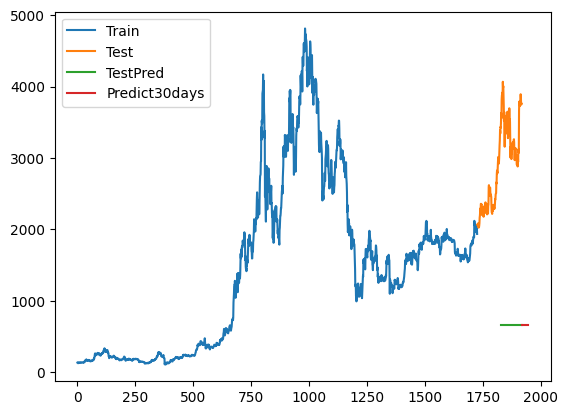

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict30days'])
plt.show()

<h2> 60 days

In [16]:
# 14. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

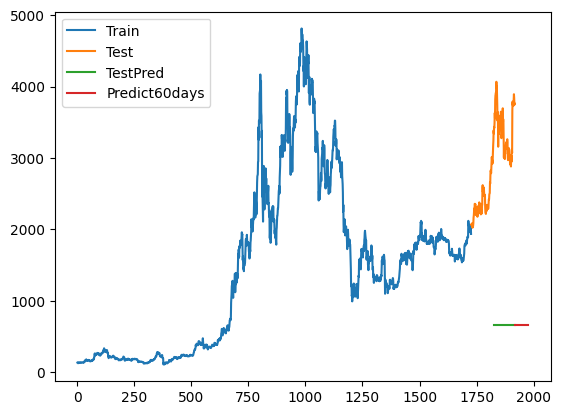

In [17]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict60days'])
plt.show()

<h2> 90 days

In [18]:
# 16. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

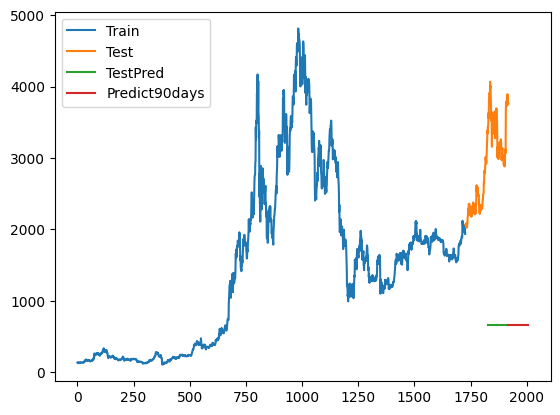

In [19]:
# 17.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict90days'])
plt.show()